In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import extract_correct_csv
import neurokit2 as nk

## All valid subject

In [2]:
valid_subject = extract_correct_csv.extract_only_valid_subject()
valid_subject

[2, 4, 10, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]

In [3]:
columns = list(pd.read_csv('../osf-storage-archive/eye/pupil/Look002_pupil.csv', sep=';', decimal=',').columns)
col_ = ['expectancy', 'shock']
columns = columns + col_

In [4]:
generic_df = pd.DataFrame(columns=columns)
for x in valid_subject:
    cur_sub = extract_correct_csv.read_correct_subject_csv(x)
    subject = pd.read_csv('data/LookAtMe_0'+cur_sub+'.csv', sep='\t')
    pupil_subj = pd.read_csv('../osf-storage-archive/eye/pupil/Look0'+cur_sub+'_pupil.csv', sep=';', decimal=',')
    expectancy = np.array(list([int(d > 2) for d in subject['rating']]))
    df_ = pupil_subj.copy(deep=False)
    df_['expectancy'] = expectancy
    df_['shock'] = subject['shock']
    generic_df = pd.concat([generic_df, df_], axis=0)

generic_df = generic_df.reset_index().drop(columns=['index'])

/tmp/ipykernel_35127/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_35127/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_35127/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  generic_df = pd.concat([generic_df, df_], axis=0)
/tmp/ipykernel_35127/4111651418.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype inste

In [5]:
# removing first 48 trial, keeping only generalization phase
generic_df = generic_df[48:]

In [6]:
baseline = generic_df.pd1.to_numpy()
mean_baseline = np.mean(baseline)
mean_baseline

2.3951070719941048

In [7]:
X = np.arange(-1, 6, 0.01)
# calculating mean and std of pupil diameter for
# - low exp and shock
df_LE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 0)]
df_LE_shock = df_LE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_1 = df_LE_shock.mean(axis=0)-mean_baseline
all_conf_1 = df_LE_shock.var(axis=0)/np.sqrt(len(X))

# - low exp and no shock
df_LE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 0)]
df_LE_no_shock = df_LE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_2 = df_LE_no_shock.mean(axis=0)-mean_baseline
all_conf_2 = df_LE_no_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and shock
df_HE_shock = generic_df[(generic_df.shock == True) & (generic_df.expectancy == 1)]
df_HE_shock = df_HE_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_3 = df_HE_shock.mean(axis=0)-mean_baseline
all_conf_3 = df_HE_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and no shock
df_HE_no_shock = generic_df[(generic_df.shock == False) & (generic_df.expectancy == 1)]
df_HE_no_shock = df_HE_no_shock.drop(columns=['trial', 'expectancy', 'shock'])
all_mean_4 = df_HE_no_shock.mean(axis=0)-mean_baseline
all_conf_4 = df_HE_no_shock.std(axis=0)/np.sqrt(len(X))


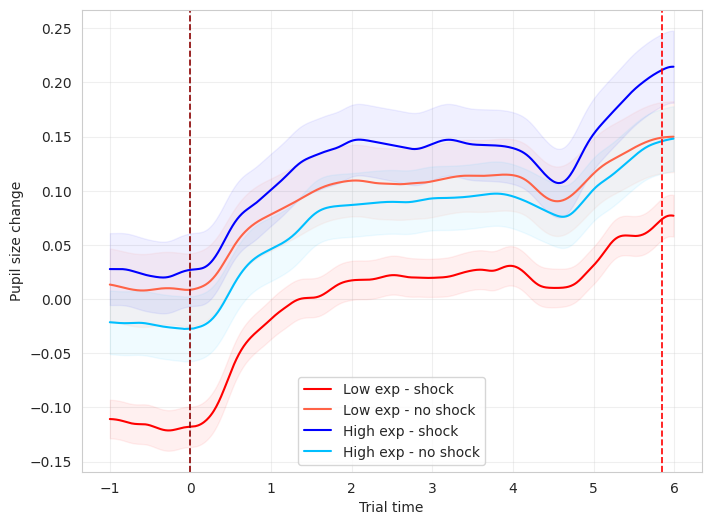

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8,6))
LE_shock_line = plt.plot(X, all_mean_1, 'r-', label='Low exp - shock')
LE_shock_fill = plt.fill_between(X, all_mean_1 - all_conf_1, all_mean_1 + all_conf_1, color = 'r', alpha=0.06)

LE_no_line = plt.plot(X, all_mean_2, 'tomato', label='Low exp - no shock')
LE_no_fill = plt.fill_between(X, all_mean_2 - all_conf_2, all_mean_2 + all_conf_2, color = 'tomato', alpha=0.06)

HE_shock_line = plt.plot(X, all_mean_3, 'b-', label='High exp - shock')
HE_shock_fill = plt.fill_between(X, all_mean_3 - all_conf_3, all_mean_3 + all_conf_3, color = 'b', alpha=0.06)

HE_no_line = plt.plot(X, all_mean_4, 'deepskyblue', label='High exp - no shock')
HE_no_fill = plt.fill_between(X, all_mean_4 - all_conf_4, all_mean_4 + all_conf_4, color = 'deepskyblue', alpha=0.06)
plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('Pupil size change')
plt.show()

## Single signal eda

In [9]:
valid_subject = extract_correct_csv.extract_only_valid_subject()

not_valid = {4, 43, 45, 50}

valid_subject = [ele for ele in valid_subject if ele not in not_valid]

In [22]:
subject = pd.read_csv('data_fake/eda/2_eda.csv')
shock = pd.read_csv('csv_shock.csv')
shock = shock.drop(columns=shock.columns[0])

eda_processed = []

for x in range(len(subject)):
    row = subject.loc[x]
    signals, info = nk.eda_process(row, sampling_rate=500)
    eda_processed.append(signals['EDA_Phasic'].to_numpy())
eda_processed = pd.DataFrame(eda_processed)

0       1.040543
1       1.038588
2       1.037607
3       1.037836
4       1.039324
          ...   
2995    1.540891
2996    1.540130
2997    1.538880
2998    1.537330
2999    1.535668
Name: 0, Length: 3000, dtype: float64
0       1.051665
1       1.053052
2       1.054724
3       1.056593
4       1.058572
          ...   
2995    1.531270
2996    1.531562
2997    1.531460
2998    1.530876
2999    1.529873
Name: 1, Length: 3000, dtype: float64
0       1.074020
1       1.074508
2       1.075078
3       1.075695
4       1.076326
          ...   
2995    1.009702
2996    1.008722
2997    1.007522
2998    1.006246
2999    1.005041
Name: 2, Length: 3000, dtype: float64
0       1.110611
1       1.113890
2       1.116402
3       1.117865
4       1.118000
          ...   
2995    1.032826
2996    1.033888
2997    1.035389
2998    1.037232
2999    1.039321
Name: 3, Length: 3000, dtype: float64
0       1.052525
1       1.051920
2       1.051851
3       1.052255
4       1.053055
          ...  

In [27]:
df_eda = eda_processed.copy(deep=False)
shock_sub = shock[shock.subject==2]
expectancy = np.array(list([int(d > 2) for d in shock_sub['rating']]))
df_eda['expectancy'] = expectancy
df_eda['shock'] = shock['shock']
df_eda = df_eda[48:]

,0,1,2,3,4,5,6,7,8,9,...,2992,2993,2994,2995,2996,2997,2998,2999,expectancy,shock
48,-0.042280,-0.042602,-0.042924,-0.043243,-0.043561,-0.043877,-0.044190,-0.044501,-0.044810,-0.045116,...,0.003346,0.003134,0.002923,0.002714,0.002506,0.002300,0.002094,0.001889,1,False
49,0.019218,0.018807,0.018399,0.017994,0.017594,0.017198,0.016807,0.016420,0.016039,0.015663,...,-0.000120,-0.000114,-0.000107,-0.000099,-0.000091,-0.000083,-0.000075,-0.000066,1,True
50,-0.022602,-0.022451,-0.022298,-0.022142,-0.021985,-0.021824,-0.021662,-0.021497,-0.021330,-0.021160,...,-0.000264,-0.000249,-0.000233,-0.000217,-0.000200,-0.000182,-0.000165,-0.000146,1,False
51,0.021090,0.020701,0.020309,0.019913,0.019512,0.019109,0.018702,0.018291,0.017878,0.017463,...,-0.000530,-0.000497,-0.000464,-0.000431,-0.000398,-0.000364,-0.000331,-0.000297,1,False
52,-0.022339,-0.021894,-0.021445,-0.020990,-0.020531,-0.020067,-0.019599,-0.019126,-0.018649,-0.018168,...,-0.000230,-0.000217,-0.000203,-0.000189,-0.000174,-0.000159,-0.000143,-0.000127,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.023852,0.023880,0.023911,0.023945,0.023980,0.024019,0.024060,0.024104,0.024150,0.024199,...,-0.000139,-0.000131,-0.000122,-0.000114,-0.000105,-0.000096,-0.000087,-0.000077,0,False
156,0.102978,0.102556,0.102133,0.101710,0.101288,0.100867,0.100446,0.100026,0.099607,0.099190,...,-0.001450,-0.001359,-0.001268,-0.001178,-0.001087,-0.000997,-0.000907,-0.000817,0,False
157,-0.013544,-0.014179,-0.014816,-0.015453,-0.016091,-0.016730,-0.017367,-0.018005,-0.018641,-0.019276,...,-0.000252,-0.000238,-0.000222,-0.000207,-0.000191,-0.000174,-0.000157,-0.000140,0,False
158,0.059079,0.059031,0.058976,0.058915,0.058848,0.058775,0.058696,0.058610,0.058517,0.058418,...,-0.000089,-0.000084,-0.000079,-0.000073,-0.000067,-0.000061,-0.000055,-0.000048,0,False


In [30]:
X = np.arange(0, 6, 0.002)
# calculating mean and std of EDA for
# - low exp and shock
df_EDA_LE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_shock = df_EDA_LE_shock.mean(axis=0)
conf_sing_LE_shock = df_EDA_LE_shock.var(axis=0)/np.sqrt(len(X))

# - low exp and no shock
df_EDA_LE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 0)].drop(columns=['expectancy', 'shock'])
mean_sing_LE_no= df_EDA_LE_no.mean(axis=0)
conf_sing_LE_no = df_EDA_LE_no.std(axis=0)/np.sqrt(len(X))

# - high exp and shock
df_EDA_HE_shock = df_eda[(df_eda.shock == True) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_shock = df_EDA_HE_shock.mean(axis=0)
conf_sing_HE_shock = df_EDA_HE_shock.std(axis=0)/np.sqrt(len(X))

# - high exp and no shock
df_EDA_HE_no = df_eda[(df_eda.shock == False) & (df_eda.expectancy == 1)].drop(columns=['expectancy', 'shock'])
mean_sing_HE_no = df_EDA_HE_no.mean(axis=0)
conf_sing_HE_no = df_EDA_HE_no.std(axis=0)/np.sqrt(len(X))

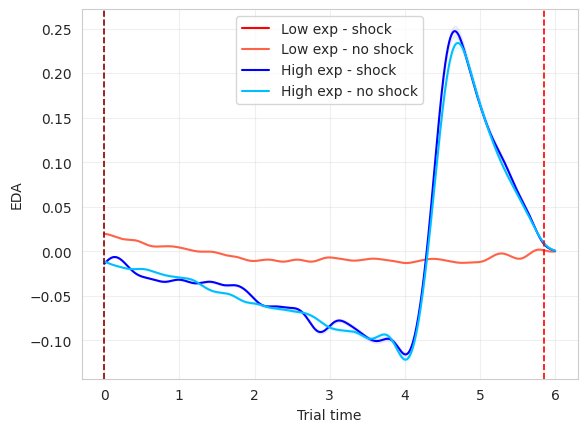

In [33]:
plt.plot(X, mean_sing_LE_shock, 'r-', label='Low exp - shock')
plt.fill_between(X, mean_sing_LE_shock - conf_sing_LE_shock, mean_sing_LE_shock + conf_sing_LE_shock, color = 'r', alpha=0.06)

plt.plot(X, mean_sing_LE_no, 'tomato', label='Low exp - no shock')
plt.fill_between(X, mean_sing_LE_no - conf_sing_LE_no, mean_sing_LE_no + conf_sing_LE_no, color = 'tomato', alpha=0.06)

plt.plot(X, mean_sing_HE_shock, 'b-', label='High exp - shock')
plt.fill_between(X, mean_sing_HE_shock - conf_sing_HE_shock, mean_sing_HE_shock + conf_sing_HE_shock, color = 'b', alpha=0.06)

plt.plot(X, mean_sing_HE_no, 'deepskyblue', label='High exp - no shock')
plt.fill_between(X, mean_sing_HE_no - conf_sing_HE_no, mean_sing_HE_no + conf_sing_HE_no, color = 'deepskyblue', alpha=0.06)

plt.axvline(x=5.85, linestyle='--', color='r', lw=1.2)
plt.axvline(x=0, linestyle='--', color='darkred', lw=1.2)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.xlabel('Trial time')
plt.ylabel('EDA')
plt.show()